In [1]:
# import required libraries for scraping data
from urllib.request import urlopen, Request
!pip install bs4
from bs4 import BeautifulSoup
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

Because the FINVIZ website only shows as many articles as the page can fit, we may not start out with enough articles
collected (per ticker). For use in the future, we may then want to scrape the website and then save that data as a .csv file. That means that (in the future) we can run sentiment analysis on a selected timeframe of our choosing (e.g. over one month rather than over 5 days).

In [2]:
# scrape article titles from FINVIZ
finviz_url = 'https://finviz.com/quote.ashx?t='                      # the common factor of all ticker urls
tickers = ['TSLA', 'AAPL', 'FB']

news_tables = {}                                                     # dictionary to store news data found in a table within
                                                                     # the source code

for ticker in tickers:
    url = finviz_url + ticker                                        # specify url format
    req = Request(url=url, headers={'user-agent': 'my-app'})         # verify user access
    response = urlopen(req)                                          # open the request
    
    html = BeautifulSoup(response, 'html')                           # mention html parser 
    news_table = html.find(id='news-table')                          # retrieve html object of the news table
    news_tables[ticker] = news_table                                 # store data by key 'ticker'

In [3]:
# open csv file as write
file = open('finvizData.csv', 'w', newline='')                       # newline='' prevents empty rows b/w rows
writer = csv.writer(file)

# specify header row
writer.writerow(['Ticker','Date','Time','News_Title'])

# write scraped data into the csv file
for ticker, news_table in news_tables.items():                       # iterate over key, value pairs in news_tables
    
    for row in news_table.findAll('tr'):                             
        
        title = row.a.text                                           # get title of the news article by tag 'a'
        date_data = row.td.text.split(' ')                           # get date data by tag 'td' + split by 'space'
        
        if len(date_data) == 1:                                      # split the date_data to retrieve both time and date
            time = date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]
        
        writer.writerow([ticker, date, time, title])
        
file.close()

We have now saved the scraped data to a .csv file. However, the dataframe below visualises a snippet of the data we've saved.

In [4]:
# create dataframe
sample = pd.DataFrame(columns=['Ticker', 'Date', 'Time', 'News_Title'])                                                 

for ticker, news_table in news_tables.items():                       
    
    for row in news_table.findAll('tr'):                             
        
        title = row.a.text                                          
        date_data = row.td.text.split(' ')                           
        
        if len(date_data) == 1:                                     
            time = date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]
        
        sample = sample.append({                                     # for each row (article) append the ticker, date, time, 
                    'Ticker': ticker, 'Date': date,                  # and news title to the dataframe we created
                    'Time': time, 'News_Title': title},
                    ignore_index = True)
sample

,Ticker,Date,Time,News_Title
0,TSLA,Sep-07-21,11:10AM,Mobileye to launch robotaxis in Germany next y...
1,TSLA,Sep-07-21,10:58AM,Dow Jones Drops As Apple Hits New High; Four T...
2,TSLA,Sep-07-21,10:56AM,People will go EV because theyre proving to be...
3,TSLA,Sep-07-21,10:37AM,Self-Driving Cars Are Here and the Leaders May...
4,TSLA,Sep-07-21,10:13AM,Is Lucid Motors Stock A Buy Right Now As Lock-...
...,...,...,...,...
295,FB,Aug-25-21,06:30AM,EU extends deadline on Facebook's Kustomer dea...
296,FB,Aug-25-21,05:48AM,"Apple, Google App Store Models Face New Threat..."
297,FB,Aug-24-21,06:38PM,Facebook Considers Building NFT Features Along...
298,FB,Aug-24-21,04:50PM,The FTCs antitrust case against Facebook fails...


In [5]:
# import dependencies for sentiment analysis using the neural network I created in ./Natural_Language_Classification
import tensorflow as tf
import numpy as np
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
# load data from csv file into dataframe
df = pd.read_csv('finvizData.csv', encoding = 'unicode_escape')          # encoding required for unicode decode error
df

,Ticker,Date,Time,News_Title
0,TSLA,Sep-07-21,11:10AM,Mobileye to launch robotaxis in Germany next y...
1,TSLA,Sep-07-21,10:58AM,Dow Jones Drops As Apple Hits New High; Four T...
2,TSLA,Sep-07-21,10:56AM,People will go EV because theyre proving to be...
3,TSLA,Sep-07-21,10:37AM,Self-Driving Cars Are Here and the Leaders May...
4,TSLA,Sep-07-21,10:13AM,Is Lucid Motors Stock A Buy Right Now As Lock-...
...,...,...,...,...
295,FB,Aug-25-21,06:30AM,EU extends deadline on Facebook's Kustomer dea...
296,FB,Aug-25-21,05:48AM,"Apple, Google App Store Models Face New Threat..."
297,FB,Aug-24-21,06:38PM,Facebook Considers Building NFT Features Along...
298,FB,Aug-24-21,04:50PM,The FTCs antitrust case against Facebook fails...


In [7]:
# load tokenizer
with open('./tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# load model
model = tf.keras.models.load_model('./model_1')

In [8]:
# set variables
oov_tok = '<OOV>'
padding_type = 'post'
trunc_type = 'post'
vocab_size = 1000
max_length = 142

# create function so that we can mass-preprocess the sentences (news titles)
def preprocessText(text):
    sequences = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(sequences,
                           maxlen=max_length,
                           padding=padding_type,
                           truncating=trunc_type)
    return padded

# preprocess entire 'News Title' column
prep = preprocessText(df['News_Title'])

In [9]:
# implement sentiment prediction on our scraped data
prep = model.predict(prep)
prep[:10]

array([[0.08357877, 0.44633362, 0.47008762],
       [0.02675995, 0.5726797 , 0.40056032],
       [0.2368267 , 0.2994776 , 0.46369562],
       [0.13792846, 0.38309664, 0.47897488],
       [0.01171632, 0.6428368 , 0.34544683],
       [0.01554439, 0.6278971 , 0.35655853],
       [0.01322436, 0.63819003, 0.34858558],
       [0.04347167, 0.52230877, 0.43421954],
       [0.11832964, 0.40578926, 0.47588113],
       [0.02151626, 0.595079  , 0.3834047 ]], dtype=float32)

In [10]:
# create a new column that stores the predicted sentiment
df['Sentiment'] = np.argmax(prep, axis = -1)
df

,Ticker,Date,Time,News_Title,Sentiment
0,TSLA,Sep-07-21,11:10AM,Mobileye to launch robotaxis in Germany next y...,2
1,TSLA,Sep-07-21,10:58AM,Dow Jones Drops As Apple Hits New High; Four T...,1
2,TSLA,Sep-07-21,10:56AM,People will go EV because theyre proving to be...,2
3,TSLA,Sep-07-21,10:37AM,Self-Driving Cars Are Here and the Leaders May...,2
4,TSLA,Sep-07-21,10:13AM,Is Lucid Motors Stock A Buy Right Now As Lock-...,1
...,...,...,...,...,...
295,FB,Aug-25-21,06:30AM,EU extends deadline on Facebook's Kustomer dea...,2
296,FB,Aug-25-21,05:48AM,"Apple, Google App Store Models Face New Threat...",1
297,FB,Aug-24-21,06:38PM,Facebook Considers Building NFT Features Along...,2
298,FB,Aug-24-21,04:50PM,The FTCs antitrust case against Facebook fails...,2


Some examples: (recall 0:Negative, 1:Neutral, 2:Positive)

In [53]:
df.iloc[95]

Ticker                                               TSLA
Date                                           2021-08-31
Time                                            07:45AM  
News_Title    3 Things to Do After Your First Bitcoin Buy
Sentiment                                               2
Name: 95, dtype: object

In [57]:
df.iloc[210]

Ticker                                              FB
Date                                        2021-09-03
Time                                         12:23PM  
News_Title    Michael Burry Is Selling These 15 Stocks
Sentiment                                            1
Name: 210, dtype: object

In [78]:
df.iloc[170]

Ticker                                     AAPL
Date                                 2021-09-01
Time                                  04:59PM  
News_Title    10 Tech Stocks that Pay Dividends
Sentiment                                     0
Name: 170, dtype: object

Notice that the quoted headlines above don't explicitly discuss the stocks in question (e.g. "Apple Q2 earnings beat expectations"). For example, the headline "3 Things to Do After Your First Bitcoin Buy" doesn't have much to do with Tesla, though the neural network has likely picked up the words "First" and "Buy" as a positive association. 

Unfortunately, we can also see that the logic of the neural network is struggling to match the data as I would certainly flag "Michael Burry is Selling..." as a negative sentiment. Similarly, it is hard to see how the headline "Tech Stocks that Pay Dividends" may be interpreted as a negative sentiment for AAPL.

Furthermore, in the barchart below, we can see that the results are heavily skewed towards a positive sentiment. Whilst this does not inherently imply that my model has not performed well, it does concern me that the model may have some statistical bias. Some initial solutions that come to mind are the need for a larger training dataset as well as a longer timeframe for for the articles to span.

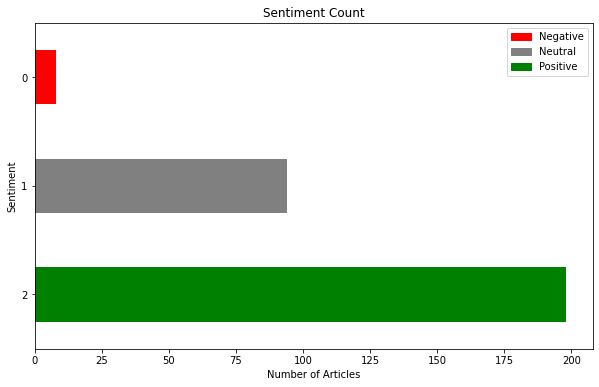

In [11]:
# create bar chart to visualise sentiment count
df['Sentiment'].value_counts().plot(kind='barh', color=['green','grey','red'])
plt.title('Sentiment Count')
plt.xlabel('Number of Articles')
plt.ylabel('Sentiment')

# creating legend 
red_patch = mpatches.Patch(color='red', label='Negative')
grey_patch = mpatches.Patch(color='grey', label='Neutral')
green_patch = mpatches.Patch(color='green', label='Positive')
plt.legend(handles=[red_patch, grey_patch, green_patch])
plt.show()

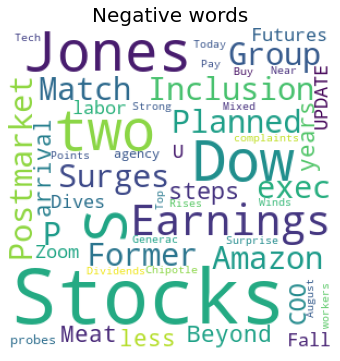

In [50]:
# function for wordcloud generation
def wordcount_cloud(df, sentiment):
    '''
    Generates word cloud
    inputs:
        - df (the scraped news headlines)
        - sentiment (positive/negative/neutral)
    '''
    # combine text by sentiment category
    comb_text = " ".join([title for title in df[df['Sentiment']==sentiment]['News_Title']])
    
    # assigning sentiment values
    if sentiment == 0:
        x = 'Negative'
    elif sentiment == 1:
        x = 'Neutral'
    else:
        x = 'Positive'
    
    # adding additional stopwords
    stop_words = ['Tesla', 'Apple', 'Facebook'] + list(STOPWORDS)
    
    # generate and plot wordcloud
    wc = WordCloud(background_color='white',
                   max_words=50,
                   stopwords=stop_words,
                   height=300,
                   width=300)
    
    plt.imshow(wc.generate(comb_text))
    plt.title(f'{x} words', fontsize=20)
    plt.axis('off')
    plt.show
    
wordcount_cloud(df, 0)

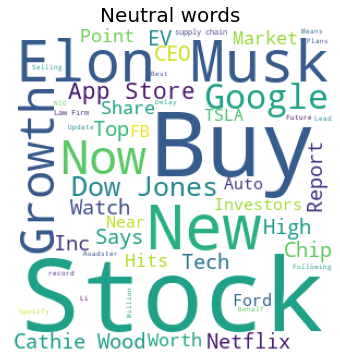

In [51]:
wordcount_cloud(df, 1)

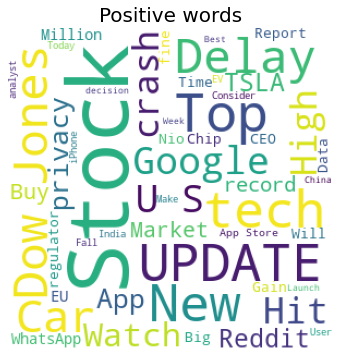

In [52]:
wordcount_cloud(df, 2)